<a href="https://colab.research.google.com/github/pren1/VAST/blob/master/VTB_classifier_playground.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!rm -rf VAST/
!git clone https://github.com/pren1/VAST.git
!pip3 install soundfile
!pip3 install librosa

Cloning into 'VAST'...
remote: Enumerating objects: 91, done.
remote: Counting objects: 100% (91/91), done.
remote: Compressing objects: 100% (65/65), done.
remote: Total 91 (delta 39), reused 51 (delta 18), pack-reused 0
Unpacking objects: 100% (91/91), done.


In [0]:
from VAST.util import *
import pdb
import pprint
from tqdm import tqdm
import numpy as np
import IPython
import soundfile as sf
import matplotlib.pyplot as plt
import librosa
import os

### Prepare dataset

In [3]:
from google.colab import drive
drive.mount('/content/gdrive')

# !gdown https://drive.google.com/uc?id=14AT3AGwNtPMRaFGN7VE2rf2BHrN4ImSd
# !gdown https://drive.google.com/uc?id=16124JngZYtz-xt5p_KBdsuo4lXN-TDCW

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


### We save the data as some batches

In [0]:
def load_data():
  data_folder = "gdrive/My Drive/CLIPPED_VAST/"
  label_folder = "gdrive/My Drive/CLIPPED_VAST/"
  data = []
  label = []
  for i in tqdm(range(6)):
    data.append(load_data_array_from_npy(data_folder + f"dataset_{i}.npy"))
    label.extend(load_data_array_from_npy(label_folder + f"labelset_{i}.npy"))

  # data.append(load_data_array_from_npy(data_folder + f"add_data.npy"))
  # label.extend(load_data_array_from_npy(label_folder + f"add_label.npy"))
  data = np.vstack(data)
  return data, label

def save_function_as_batchs(Batch_size = 2048, save_path = "gdrive/My Drive/Free_RAM_VAST/"):
  data, label = load_data()
  save_index = 0
  create_folders(save_path)
  for index in tqdm(range(0, len(label), Batch_size)):
    data_clip = data[index:index + Batch_size]
    label_clip = label[index:index + Batch_size]
    if len(data_clip) == Batch_size:
      'save data'
      save_data_array_as_npy(data_clip, save_path + f'data_{save_index}')
      save_data_array_as_npy(label_clip, save_path + f'label_{save_index}')
      save_index += 1

In [5]:
save_function_as_batchs()

100%|██████████| 86/86 [04:28<00:00,  3.12s/it]


### Take a look at the loaded data

In [0]:
for i in range(3):
  plt.plot(data[i], color = 'orange', label='read in sample data')
  plt.title(f"Label: {label[i]}")
  plt.show()
  IPython.display.display(IPython.display.Audio(np.asarray(data[i]).T, rate=8000))

### See if the preprocess part works correct

In [0]:
sample_rate = 8000

In [0]:
from keras.models import Sequential
from kapre.time_frequency import Melspectrogram, Spectrogram
from kapre.utils import Normalization2D

melspecModel = Sequential() 

melspecModel.add(Melspectrogram(n_dft=1024, n_hop=128, input_shape=(1, data.shape[-1]),
                         padding='same', sr=sample_rate, n_mels=80,
                         fmin=40.0, fmax=sample_rate/2, power_melgram=1.0,
                         return_decibel_melgram=True, trainable_fb=False,
                         trainable_kernel=False,
                         name='mel_stft') )

melspecModel.add(Normalization2D(int_axis=0))

melspecModel.summary()

In [0]:
test_input = np.expand_dims(np.expand_dims(data[0], 0), 0)
print(f"test_input shape: {test_input.shape}")
melspec = melspecModel.predict(test_input)
print(f"melspec shape: {melspec.shape}")

plt.figure(figsize=(17,6))
plt.pcolormesh(melspec[0,:,:,0])

plt.title('Spectrogram visualization')
plt.ylabel('Frequency')
plt.xlabel('Time')

plt.show()

### Check if mel spectrogram matches the one computed with librosa

In [0]:
librosa_melspec = librosa.feature.melspectrogram(y=data[0], sr=sample_rate, n_fft=1024,
                                                 hop_length=128, power=1.0, #window='hann',
                                                 n_mels=80, fmin=40.0, fmax=sample_rate/2)
S_dB = librosa.power_to_db(librosa_melspec, ref=np.max)
plt.figure(figsize=(17,6))
plt.pcolormesh(S_dB)

plt.title('Spectrogram visualization - librosa')
plt.ylabel('Frequency')
plt.xlabel('Time')

plt.show()

### Get class balance weights

In [0]:
from sklearn.utils import class_weight
class_weights = class_weight.compute_class_weight('balanced',
                                                 np.unique(label),
                                                 label)
class_weights

### Split train set & test set

In [0]:
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical

'Turn to one-hot'
idx = np.arange(len(data))
np.random.shuffle(idx)
train_idx = idx[:int(0.8*len(idx))]
test_idx = idx[int(0.8*len(idx)):]

In [0]:
data = np.asarray(data)
label = np.asarray(label)

In [0]:
train_idx[:3000] = np.arange(len(data)-3000, len(data))

In [0]:
train_idx[0]

In [0]:
# X_test = data[test_idx]
# y_test = to_categorical(label[test_idx])

# X_train = data[train_idx]
# y_train = to_categorical(label[train_idx])

# # data, X_test, label, y_test = train_test_split(data, label, test_size=0.2, random_state=42)

In [0]:
# print(f"X_train shape: {data.shape}")
# print(f"label shape: {label.shape}")

# print(f"X_test shape: {X_test.shape}")
# print(f"y_test shape: {y_test.shape}")

In [0]:
label.shape

### A toy CNN + LSTM + attention classifier 

In [6]:
from keras import layers as L
import keras.backend as K
from keras.models import Model
from keras.callbacks import LearningRateScheduler
import math
import keras
from kapre.time_frequency import Melspectrogram, Spectrogram
from kapre.utils import Normalization2D

'define model'
def AttRNNSpeechModel(nCategories, dropout_rate, samplingrate=8000,
                      inputLength=8000, rnn_func=L.LSTM):
    # simple LSTM
    sr = samplingrate
    iLen = inputLength
    dropout_rate = dropout_rate

    inputs = L.Input((inputLength,), name='input')

    x = L.Reshape((1, -1))(inputs)

    m = Melspectrogram(n_dft=1024, n_hop=128, input_shape=(1, iLen),
                       padding='same', sr=sr, n_mels=80,
                       fmin=40.0, fmax=sr / 2, power_melgram=1.0,
                       return_decibel_melgram=True, trainable_fb=False,
                       trainable_kernel=False,
                       name='mel_stft')
    m.trainable = False

    x = m(x)

    x = Normalization2D(int_axis=0, name='mel_stft_norm')(x)

    # note that Melspectrogram puts the sequence in shape (batch_size, melDim, timeSteps, 1)
    # we would rather have it the other way around for LSTMs

    x = L.Permute((2, 1, 3))(x)

    x = L.Conv2D(10, (5, 1), activation='relu', padding='same')(x)
    x = L.BatchNormalization()(x)
    x = L.Dropout(dropout_rate)(x)
    
    x = L.Conv2D(1, (5, 1), activation='relu', padding='same')(x)
    x = L.BatchNormalization()(x)
    x = L.Dropout(dropout_rate)(x)

    # x = Reshape((125, 80)) (x)
    # keras.backend.squeeze(x, axis)
    x = L.Lambda(lambda q: K.squeeze(q, -1), name='squeeze_last_dim')(x)

    x = L.Bidirectional(rnn_func(64, return_sequences=True)
                        )(x)  # [b_s, seq_len, vec_dim]
    
    x = L.Dropout(dropout_rate)(x)                    
    x = L.Bidirectional(rnn_func(64, return_sequences=True)
                        )(x)  # [b_s, seq_len, vec_dim]

    xFirst = L.Lambda(lambda q: q[:, -1])(x)  # [b_s, vec_dim]
    query = L.Dense(128)(xFirst)

    # dot product attention
    attScores = L.Dot(axes=[1, 2])([query, x])
    attScores = L.Softmax(name='attSoftmax')(attScores)  # [b_s, seq_len]

    # rescale sequence
    attVector = L.Dot(axes=[1, 1])([attScores, x])  # [b_s, vec_dim]

    x = L.Dense(64, activation='relu')(attVector)
    x = L.Dense(32)(x)

    output = L.Dense(nCategories, activation='softmax', name='output')(x)

    model = Model(inputs=[inputs], outputs=[output])

    return model

'learning rate decay'
def step_decay(self, epoch):
    initial_lrate = 0.01
    drop = 0.5
    epochs_drop = 2.0
    lrate = initial_lrate * math.pow(drop, math.floor((1 + epoch) / epochs_drop))
    return lrate    

Using TensorFlow backend.


In [7]:
model = AttRNNSpeechModel(4, dropout_rate=0.1)
model.compile(optimizer='adam', loss=['categorical_crossentropy'], metrics=['categorical_accuracy'])
# model.compile(optimizer='adam', loss=[multi_category_focal_loss2_fixed], metrics=['categorical_accuracy'])
model.summary()
lrate = LearningRateScheduler(step_decay)

tracking <tf.Variable 'mel_stft/real_kernels:0' shape=(1024, 1, 1, 513) dtype=float32> dft_real_kernels
tracking <tf.Variable 'mel_stft/imag_kernels:0' shape=(1024, 1, 1, 513) dtype=float32> dft_imag_kernels
tracking <tf.Variable 'mel_stft/Variable:0' shape=(513, 80) dtype=float32> freq2mel
Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              (None, 8000)         0                                            
__________________________________________________________________________________________________
reshape_1 (Reshape)             (None, 1, 8000)      0           input[0][0]                      
__________________________________________________________________________________________________
mel_stft (Melspectrogram)       (None, 80, 63, 1)    1091664     reshape_1[0][0]                 

### Define data generator

In [0]:
# class DataGenerator(keras.utils.Sequence):
#     'Generates data for Keras'
#     def __init__(self, list_IDs, input_path, dim = 8000, batch_size=2048,
#                  n_classes=4, shuffle=True):
#         'Initialization'
#         self.dim = dim
#         self.batch_size = batch_size
#         self.input_path = input_path
#         self.list_IDs = list_IDs
#         self.n_classes = n_classes
#         self.shuffle = shuffle
#         self.on_epoch_end()

#     def __len__(self):
#         'Denotes the number of batches per epoch'
#         return int(np.floor(len(self.list_IDs) / self.batch_size))

#     def __getitem__(self, index):
#         'Generate one batch of data'
#         # Generate indexes of the batch
#         indexes = self.indexes[index : index+1]

#         # Find list of IDs
#         list_IDs_temp = [self.list_IDs[k] for k in indexes]

#         # Generate data
#         X, y = self.__data_generation(list_IDs_temp)

#         return X, y

#     def on_epoch_end(self):
#         'Updates indexes after each epoch'
#         self.indexes = np.arange(len(self.list_IDs))
#         if self.shuffle == True:
#             print("list Shuffled")
#             np.random.shuffle(self.indexes)

#     def __data_generation(self, list_IDs_temp):
#         'Generates data containing batch_size samples' # X : (n_samples, *dim, n_channels)
#         # Initialization
#         X = np.empty((self.batch_size, self.dim))
#         y = np.empty((self.batch_size), dtype=int)

#         assert len(list_IDs_temp) == 1
#         # Generate data
#         ID = list_IDs_temp[0]
#         # Store sample
#         X = load_data_array_from_npy(self.input_path + f'data_{ID}.npy')

#         # Store class
#         y = load_data_array_from_npy(self.input_path + f'label_{ID}.npy')
#         return X, keras.utils.to_categorical(y, num_classes=self.n_classes)

def DataGenerator(id_list, input_path, batch_size = 2048, dim = 8000, n_classes = 4):
  # Create empty arrays to contain batch of features and labels#
  X = np.empty((batch_size, dim))
  y = np.empty((batch_size), dtype=int)
  while True:
    # choose a random ID
    ID = np.random.choice(id_list,1)[0]
    # Store sample
    X = load_data_array_from_npy(input_path + f'data_{ID}.npy')
    # Store class
    y = load_data_array_from_npy(input_path + f'label_{ID}.npy')
    
    yield X, keras.utils.to_categorical(y, num_classes=n_classes)

In [0]:
def generate_generator(input_path = "gdrive/My Drive/Free_RAM_VAST/"):
  all_files = files_in_target_folder(input_path, '.npy')
  range_index = np.arange(len(all_files)//2)
  np.random.shuffle(range_index)
  train_ratio = 0.8

  train_list = range_index[:int(train_ratio * len(range_index))]
  test_list = range_index[int(train_ratio * len(range_index)):]

  train_generator = DataGenerator(train_list, input_path=input_path)
  test_generator = DataGenerator(test_list, input_path=input_path)
  return train_generator, test_generator, len(train_list), len(test_list)

In [0]:
train_generator, test_generator, train_steps, validation_steps = generate_generator()

In [12]:
train_steps

68

### Train model

In [13]:
# results = model.fit(x = data[train_idx], y = to_categorical(label[train_idx]),
# 				epochs=30,
# 				batch_size=2048,
# 				shuffle=True,
# 				validation_data=(data[test_idx], to_categorical(label[test_idx])),
# 				callbacks=[lrate],
# 				class_weight=class_weights
# 				)
# Train model on dataset
results = model.fit_generator(generator=train_generator,
                    epochs=30,
										validation_data=test_generator,
										validation_steps = validation_steps,
										steps_per_epoch = train_steps,
										shuffle=True,
										callbacks=[lrate],
										class_weight=np.asarray([0.83401266, 1.21839585, 0.8408355 , 1.26432985])
                    )

Epoch 1/30
68/68 [==============================] - 146s 2s/step - loss: 0.5215 - categorical_accuracy: 0.7918 - val_loss: 0.6169 - val_categorical_accuracy: 0.7815
Epoch 2/30
68/68 [==============================] - 79s 1s/step - loss: 0.1744 - categorical_accuracy: 0.9393 - val_loss: 0.3040 - val_categorical_accuracy: 0.8999
Epoch 3/30
68/68 [==============================] - 83s 1s/step - loss: 0.1203 - categorical_accuracy: 0.9583 - val_loss: 0.1759 - val_categorical_accuracy: 0.9354
Epoch 4/30
68/68 [==============================] - 92s 1s/step - loss: 0.0949 - categorical_accuracy: 0.9672 - val_loss: 0.1132 - val_categorical_accuracy: 0.9538
Epoch 5/30
68/68 [==============================] - 105s 2s/step - loss: 0.0806 - categorical_accuracy: 0.9725 - val_loss: 0.1200 - val_categorical_accuracy: 0.9551
Epoch 6/30
68/68 [==============================] - 85s 1s/step - loss: 0.0689 - categorical_accuracy: 0.9757 - val_loss: 0.1259 - val_categorical_accuracy: 0.9628
Epoch 7/30
68/

### Training loss/acc curve

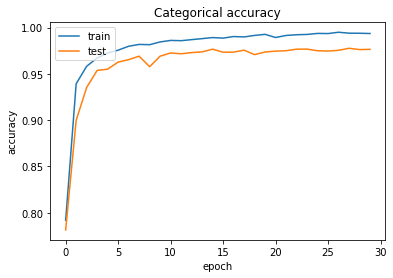

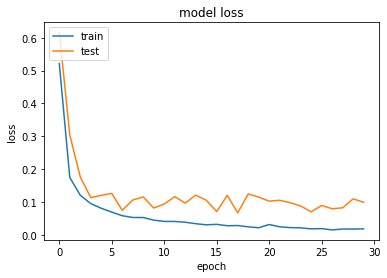

In [14]:
# summarize history for categorical accuracy
plt.plot(results.history['categorical_accuracy'])
plt.plot(results.history['val_categorical_accuracy'])
plt.title('Categorical accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(results.history['loss'])
plt.plot(results.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

### Save model

In [0]:
model.save_weights('gdrive/My Drive/four_vtb_classifier_model.h5')

In [16]:
evaluate_model = AttRNNSpeechModel(4, dropout_rate=0.1)
evaluate_model.load_weights('gdrive/My Drive/four_vtb_classifier_model.h5')

tracking <tf.Variable 'mel_stft_1/real_kernels:0' shape=(1024, 1, 1, 513) dtype=float32> dft_real_kernels
tracking <tf.Variable 'mel_stft_1/imag_kernels:0' shape=(1024, 1, 1, 513) dtype=float32> dft_imag_kernels
tracking <tf.Variable 'mel_stft_1/Variable:0' shape=(513, 80) dtype=float32> freq2mel


### Draw confusion matrix

In [18]:
from sklearn.metrics import confusion_matrix
# Get y_pred_test
y_pred = []
y_test = []
for i in tqdm(range(validation_steps)):
  data, label = next(test_generator)
  four_class_probs = evaluate_model.predict(data)
  y_pred.extend(np.argmax(four_class_probs, axis=-1))
  y_test.extend(np.argmax(label, axis=-1))

confusion_mat = confusion_matrix(y_test, y_pred)

100%|██████████| 17/17 [00:55<00:00,  3.28s/it]


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


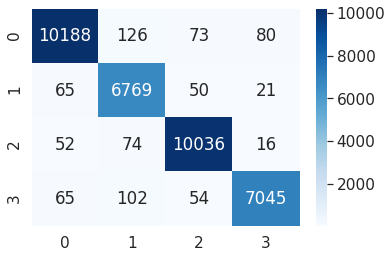

In [19]:
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt

df_cm = pd.DataFrame(confusion_mat, range(confusion_mat.shape[0]), range(confusion_mat.shape[1]))
sn.set(font_scale=1.4) # for label size
sn.heatmap(df_cm, annot=True, cmap='Blues', fmt='d')
plt.show()

In [0]:
# debug_name_list = ['宝鐘マリン', '白上フブキ', '天音かなた', '夏色まつり']

# up_total = 0

# for i in range(len(y_pred)):
#   if up_total == 50:
#     pdb.set_trace()
#   if y_pred[i] != y_test[i]:
#     plt.plot(X_test[i], color = 'orange', label='incorrect data')
#     plt.title(f"pred: {y_pred[i]}, real: {y_test[i]}")
#     plt.show()
#     print(f" 预测: {debug_name_list[y_pred[i]]}, 实际: {debug_name_list[y_test[i]]}")
#     for j in range(4):
#       print(f"{debug_name_list[j]}: {four_class_probs[i][j]}")
#     IPython.display.display(IPython.display.Audio(np.asarray(X_test[i]).T, rate=8000))
#     up_total += 1
    